In [2]:
# Split up the dataset randomly into 80% train set, 10% dev set, 10% test set.
# Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
import random # shuffle the list of words to get an even distribution

words = open('../names.txt', 'r').read().splitlines()
random.seed(230)
random.shuffle(words)
train_set = words[:int(len(words)*0.8)]
dev_set = words[int(len(words)*0.8):int(len(words)*0.9)]
test_set = words[int(len(words)*0.9):]


In [3]:
# Map the words to indexes
chars = sorted(list(set(''.join(words)))) # get the unique characters through the set() method
stoi = {s:i +1 for i,s in enumerate(chars)} # string to index
stoi['.'] = 0 # end character

itos = {i:s for s,i in stoi.items()} # index to string
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Let's now implement the Bigram Model & see how our model performs

In [4]:
## CREATE INPUT TENSOR AND LABELS

import torch

xs, ys = [], []

for w in train_set:
    with_breaks = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(with_breaks, with_breaks[1:]):
        index_one = stoi[ch1]
        index_two = stoi[ch2]

        xs.append(index_one) # this is the training set for the neural network
        ys.append(index_two)

xs = torch.tensor(xs) # convert to tensor
ys = torch.tensor(ys)

In [32]:
## SET UP MODEL PARAMETERS

import torch.nn.functional as F

# set up the model drivers
g = torch.Generator().manual_seed(2147483647)
emb_lookup = torch.randn((27, 2), generator=g) # also written as 'C'
W1 = torch.randn((2, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) # ending back up with 27 possible outputs / chars
b2 = torch.randn(27, generator=g)

# put all of the parameters in one array for neatness -- you can sum all these to get total param count
parameters = [emb_lookup, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [33]:
# Use this to try out different learning rates
lre = torch.linspace(-3, 1, 1000) # creates a tensor of 1000 linearly spaced points between 10^-3 and 10^1. Represents learning rate in exponents in log scale (base 10)
lrs = 10**lre # transforms into decimal form (ie instead of 10^-3, you have 0.01)
lrs

tensor([1.0000e-03, 1.0093e-03, 1.0186e-03, 1.0280e-03, 1.0376e-03, 1.0472e-03,
        1.0569e-03, 1.0667e-03, 1.0765e-03, 1.0865e-03, 1.0966e-03, 1.1067e-03,
        1.1170e-03, 1.1273e-03, 1.1378e-03, 1.1483e-03, 1.1589e-03, 1.1697e-03,
        1.1805e-03, 1.1915e-03, 1.2025e-03, 1.2136e-03, 1.2249e-03, 1.2362e-03,
        1.2477e-03, 1.2592e-03, 1.2709e-03, 1.2826e-03, 1.2945e-03, 1.3065e-03,
        1.3186e-03, 1.3308e-03, 1.3432e-03, 1.3556e-03, 1.3682e-03, 1.3808e-03,
        1.3936e-03, 1.4065e-03, 1.4196e-03, 1.4327e-03, 1.4460e-03, 1.4594e-03,
        1.4729e-03, 1.4865e-03, 1.5003e-03, 1.5142e-03, 1.5282e-03, 1.5424e-03,
        1.5567e-03, 1.5711e-03, 1.5856e-03, 1.6003e-03, 1.6151e-03, 1.6301e-03,
        1.6452e-03, 1.6604e-03, 1.6758e-03, 1.6913e-03, 1.7070e-03, 1.7228e-03,
        1.7388e-03, 1.7549e-03, 1.7711e-03, 1.7875e-03, 1.8041e-03, 1.8208e-03,
        1.8377e-03, 1.8547e-03, 1.8719e-03, 1.8892e-03, 1.9067e-03, 1.9244e-03,
        1.9422e-03, 1.9602e-03, 1.9783e-

In [44]:
## TRAINING THE MODEL

# Basically the same thing as running a validation / test run except with gradient updates
max_steps = 1000
loss_values = []
learning_rates = []

for k in range(max_steps): #running a loop as we're running a bunch of forward passes to get loss and optimize
    ## Make a mini batch
    # In this example, we will grab 32 rows of the lookup table
    # This is random, which can help with generalization
    ix = torch.randint(0, xs.shape[0], (32,))
    
    ## Forward pass
    # embed the input xs tensor into the lookup table
    # instead of grabbing the entire dataset as one batch to train, we get mini batches
    xs_embeddings = emb_lookup[xs[ix]]

    # feed into the two subsequent layers
    hidden_layer = torch.tanh(xs_embeddings.view(-1, 2) @ W1 + b1)
    logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, ys[ix])
    print(loss.item())

    # TODO: need to understand the L2 regularization from part one. Also less clear about functions below
    # For example: 1) why are we going through all the parameters, and 2) why aren't we updating weights.data, but all

    ## Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    '''Iteration One (Learning Rate TBD)
    # find best learning rate 
    learning_rate = lrs[k] # decimal form
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    learning_rates.append(lre[k]) # append exponential form so when we plot the visual space is more compressed
    loss_values.append(loss.item())
    '''
    

    '''Iteration Two Onwards (Learning Rate Found & Plotted)'''
    for p in parameters:
        p.data += -(0.01) * p.grad


2.5637288093566895
2.4988880157470703
2.5774083137512207
2.9827563762664795
2.9356651306152344
2.4964354038238525
2.463707685470581
2.243565320968628
2.873386859893799
4.935077667236328
2.6413300037384033
2.5174560546875
2.799797773361206
3.1549177169799805
2.314901113510132
2.190260171890259
3.8967907428741455
2.4518051147460938
2.4335696697235107
2.941324472427368
2.4555976390838623
2.673752784729004
2.888037919998169
3.924150228500366
2.794538736343384
2.626685857772827
2.522768497467041
2.761202812194824
2.682933807373047
2.4656577110290527
2.572319269180298
2.7561192512512207
2.260990619659424
2.5190587043762207
3.2520580291748047
2.2535996437072754
2.567427635192871
2.523024559020996
2.3361010551452637
2.3850748538970947
2.6967663764953613
2.7860782146453857
2.858888626098633
3.174708127975464
4.941718101501465
2.5704541206359863
2.382659673690796
3.748152494430542
3.153749942779541
2.9768760204315186
2.6006433963775635
2.5930075645446777
3.5419700145721436
2.6628565788269043
2.5

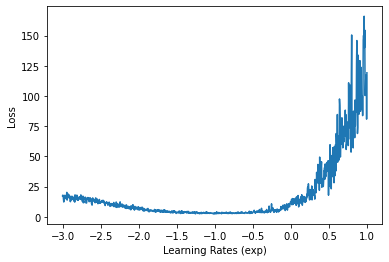

In [35]:
# PLOT LEARNING RATES TO LOSS RELATIONSHIP
# we can see that the lowest loss is quite close to 10^-1, or 0.1

import matplotlib.pyplot as plt

plt.plot(learning_rates, loss_values)
plt.xlabel("Learning Rates (exp)")
plt.ylabel("Loss")
plt.show()

In [45]:
# CHECK LOSS ON DEV_SET FORWARD PASS

# Convert the dev_set to tensors
dev_xs, dev_ys = [], []

for w in dev_set:
    with_breaks = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(with_breaks, with_breaks[1:]):
        index_one = stoi[ch1]
        index_two = stoi[ch2]

        dev_xs.append(index_one) # this is the training set for the neural network
        dev_ys.append(index_two)

dev_xs = torch.tensor(dev_xs) # convert to tensor
dev_ys = torch.tensor(dev_ys)

# Do a forward pass (without updates)
dev_xs_embeddings = emb_lookup[dev_xs]
hidden_layer = torch.tanh(dev_xs_embeddings.view(-1, 2) @ W1 + b1)
logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
loss = F.cross_entropy(logits, dev_ys)
loss

# After I run this, I can go back to the model training portion and run it again, potentially with a learning rate decay (reduce by factor of 10)
# That way I keep tuning the model and checking if training is still making a dent on the loss. 
# Iteration 1: loss went up by ~1 after running my third training run; I may be overfitting. Ideally in this case I would have implemented a checkpoint to load, but that will be in a future round
# Iteration 2: reinitialized network and decayed learning rate to 0.01, achieving loss of ~2.7

tensor(2.7809, grad_fn=<NllLossBackward0>)